In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,model_from_json , Sequential
from keras.utils import to_categorical
from keras.applications.nasnet import preprocess_input
from keras.applications import NASNetMobile , imagenet_utils
from keras.layers import Activation , Dense , Flatten ,Input, BatchNormalization , Conv2D , MaxPool2D ,MaxPooling2D, Dropout , GlobalAveragePooling2D,Conv1D,MaxPooling1D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping , ReduceLROnPlateau
from keras.regularizers import l2
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_data_dir =     '/content/drive/My Drive/DataSet_1000_for_models/train_set/'
validation_data_dir ='/content/drive/My Drive/DataSet_1000_for_models/validation_set/'
test_dir =           '/content/drive/My Drive/DataSet_1000_for_models/test_set/'

train_batches = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(224, 224),
    batch_size=10,
    shuffle=True,
    class_mode='categorical'
)

validation_batches = val_datagen.flow_from_directory(
    directory=validation_data_dir,
    target_size=(224, 224),
    batch_size=10,
    shuffle=True,
    class_mode='categorical'
)

test_batches=test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=10,
    shuffle=False,
    class_mode='categorical'
)

Found 1000 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)

# 1. **ResNet50 V2** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the base model
base_model.trainable = False

# Add classification layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

# Create the model
resnet_model = tf.keras.Model(inputs, outputs)

# Compile the model
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history_resnet = resnet_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

94668760/94668760 [==============================] - 5s 0us/step
Epoch 1/20
100/100 [==============================] - 922s 9s/step - loss: 0.4876 - accuracy: 0.8430 - val_loss: 0.2295 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - 9s 88ms/step - loss: 0.2110 - accuracy: 0.9530 - val_loss: 0.2210 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - 8s 80ms/step - loss: 0.1782 - accuracy: 0.9630 - val_loss: 0.1843 - val_accuracy: 0.9425 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - 8s 78ms/step - loss: 0.1308 - accuracy: 0.9730 - val_loss: 0.2311 - val_accuracy: 0.9175 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - 9s 88ms/step - loss: 0.1308 - accuracy: 0.9700 - val_loss: 0.1963 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 6/20
100/100 [==============================] - 8s 83ms/step - loss: 0.1219 - accuracy: 0.9700 - val_loss: 0.1647 - val_accuracy: 0.9600 - lr: 0.0010

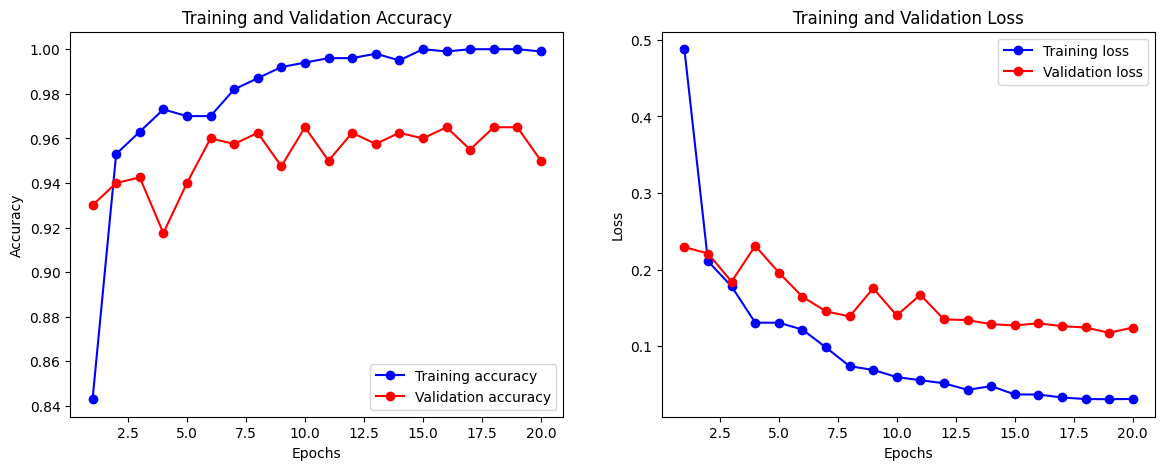

In [ ]:
# Extracting data from history
accuracy = history_resnet.history['accuracy']
val_accuracy = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_resnet = resnet_model.evaluate(train_batches,steps=len(train_batches), verbose=0)
val_score_resnet   = resnet_model.evaluate(validation_batches,steps=len(validation_batches), verbose=0)
test_score_resnet  = resnet_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss ResNet50 V2 model : {train_score_resnet[0]} ... Training accuracy ResNet50 V2 model: {train_score_resnet[1]}')
print(f'Validation loss ResNet50 V2 model: {val_score_resnet[0]} ... Validation accuracy ResNet50 V2 model: {val_score_resnet[1]}')
print(f'Test loss ResNet50 V2 model: {test_score_resnet[0]} ... Test accuracy ResNet50 V2 model: {test_score_resnet[1]}')

Training loss ResNet50 V2 model : 0.02576865255832672 ... Training accuracy ResNet50 V2 model: 1.0
Validation loss ResNet50 V2 model: 0.12443970888853073 ... Validation accuracy ResNet50 V2 model: 0.949999988079071
Test loss ResNet50 V2 model: 0.31133192777633667 ... Test accuracy ResNet50 V2 model: 0.9350000023841858


# 2. **Xception** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications.xception import Xception, preprocess_input
# Load the pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add classification layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)
xception_model = tf.keras.Model(inputs, outputs)

xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_xception = xception_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/20
100/100 [==============================] - 442s 4s/step - loss: 0.5547 - accuracy: 0.8180 - val_loss: 0.2994 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - 9s 91ms/step - loss: 0.3072 - accuracy: 0.9190 - val_loss: 0.2587 - val_accuracy: 0.9275 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - 8s 79ms/step - loss: 0.2458 - accuracy: 0.9300 - val_loss: 0.2249 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - 9s 86ms/step - loss: 0.2391 - accuracy: 0.9320 - val_loss: 0.2433 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - 9s 87ms/step - loss: 0.1814 - accuracy: 0.9590 - val_loss: 0.2016 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 6/20
100/100 [==============================] - 8s 84ms/step - loss: 0.1693 - accuracy: 0.9680 - val_loss: 0.2001 - val_accuracy: 0.9500 - lr: 0.0010

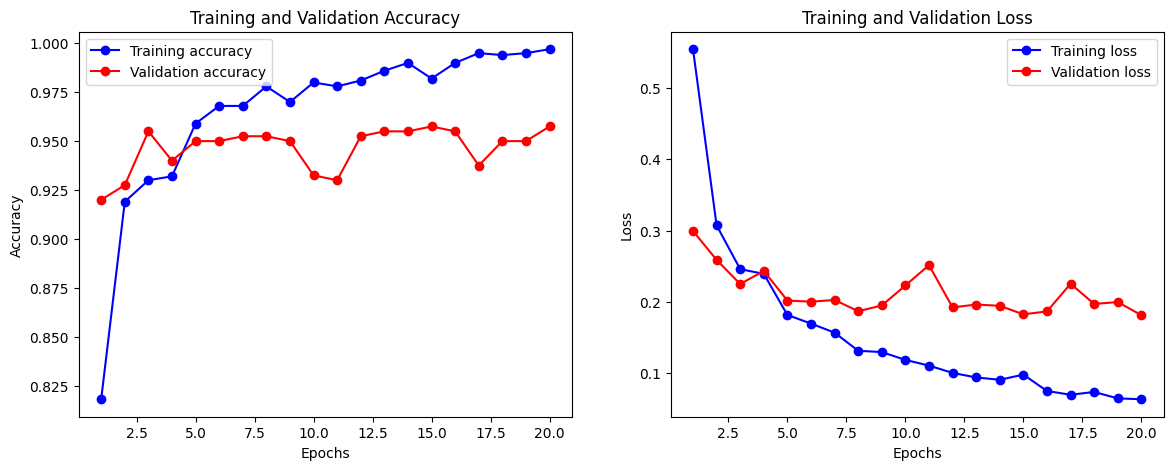

In [ ]:
# Extracting data from history
accuracy = history_xception.history['accuracy']
val_accuracy = history_xception.history['val_accuracy']
loss = history_xception.history['loss']
val_loss = history_xception.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Evaluate the model on the Sets
train_score_xception = xception_model.evaluate(train_batches,steps=len(train_batches), verbose=0)
val_score_xception   = xception_model.evaluate(validation_batches,steps=len(validation_batches), verbose=0)
test_score_xception  = xception_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss xception model  : {train_score_xception[0]} ... Training accuracy xception model:   {train_score_xception[1]}')
print(f'Validation loss xception model: {val_score_xception[0]}   ... Validation accuracy xception model: {val_score_xception[1]}')
print(f'Test loss xception model      : {test_score_xception[0]}  ... Test accuracy xception model:       {test_score_xception[1]}')

Training loss xception model  : 0.05155007168650627 ... Training accuracy xception model:   0.996999979019165
Validation loss xception model: 0.18109704554080963   ... Validation accuracy xception model: 0.9574999809265137
Test loss xception model      : 0.2387159764766693  ... Test accuracy xception model:       0.9200000166893005


# 3. **NASNet Mobile** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications import NASNetMobile

base_model = tf.keras.applications.nasnet.NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freaze Base Layers
for layer in base_model.layers:
    layer.trainable = False

# Add GlobalAveragePooling2D
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Add fully connected
fc_layer1 = tf.keras.layers.Dense(512, activation='relu')(global_average_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(fc_layer1)
fc_layer2 = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(dropout_layer)

nasnet_model = tf.keras.Model(inputs=base_model.input, outputs=fc_layer2)

nasnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history_nasnet = nasnet_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

19993432/19993432 [==============================] - 0s 0us/step
Epoch 1/20
100/100 [==============================] - 28s 144ms/step - loss: 0.5646 - accuracy: 0.8210 - val_loss: 0.2668 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - 10s 97ms/step - loss: 0.3395 - accuracy: 0.8980 - val_loss: 0.2594 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - 8s 82ms/step - loss: 0.2964 - accuracy: 0.9090 - val_loss: 0.2284 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - 9s 85ms/step - loss: 0.2508 - accuracy: 0.9300 - val_loss: 0.2110 - val_accuracy: 0.9475 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - 10s 96ms/step - loss: 0.2099 - accuracy: 0.9360 - val_loss: 0.1829 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 6/20
100/100 [==============================] - 11s 109ms/step - loss: 0.1902 - accuracy: 0.9450 - val_loss: 0.1915 - val_accuracy: 0.9500 - lr: 

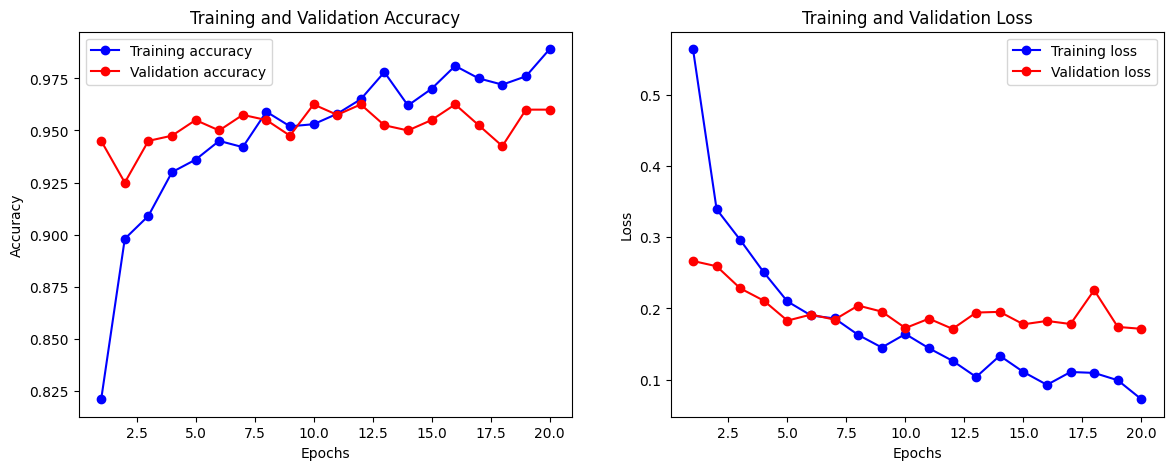

In [ ]:
# Extracting data from history
accuracy = history_nasnet.history['accuracy']
val_accuracy = history_nasnet.history['val_accuracy']
loss = history_nasnet.history['loss']
val_loss = history_nasnet.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_nasnet = nasnet_model.evaluate(train_batches,steps=len(train_batches), verbose=0)
val_score_nasnet   = nasnet_model.evaluate(validation_batches,steps=len(validation_batches), verbose=0)
test_score_nasnet  = nasnet_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss Nasnet Mobile: {train_score_nasnet[0]} ... Training accuracy Nasnet Mobile: {train_score_nasnet[1]}')
print(f'Validation loss Nasnet Mobile: {val_score_nasnet[0]} ... Validation accuracy Nasnet Mobile: {val_score_nasnet[1]}')
print(f'Test loss Nasnet Mobile: {test_score_nasnet[0]} ... Test accuracy Nasnet Mobile: {test_score_nasnet[1]}')

Training loss Nasnet Mobile: 0.05499600991606712 ... Training accuracy Nasnet Mobile: 0.996999979019165
Validation loss Nasnet Mobile: 0.17139655351638794 ... Validation accuracy Nasnet Mobile: 0.9599999785423279
Test loss Nasnet Mobile: 0.23948994278907776 ... Test accuracy Nasnet Mobile: 0.9150000214576721


# 4. **DenseNet 201** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications import DenseNet201

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)

# Create final Model
densenet_model = Model(inputs=base_model.input, outputs=predictions)

# Freze Layers (base model)
for layer in base_model.layers:
    layer.trainable = False
densenet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history_densnet = densenet_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

74836368/74836368 [==============================] - 0s 0us/step
Epoch 1/20
100/100 [==============================] - 32s 161ms/step - loss: 0.6253 - accuracy: 0.7710 - val_loss: 0.3106 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - 10s 99ms/step - loss: 0.3890 - accuracy: 0.8650 - val_loss: 0.3169 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - 10s 100ms/step - loss: 0.3012 - accuracy: 0.9080 - val_loss: 0.2183 - val_accuracy: 0.9350 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - 10s 96ms/step - loss: 0.2850 - accuracy: 0.9170 - val_loss: 0.2138 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - 10s 97ms/step - loss: 0.2572 - accuracy: 0.9230 - val_loss: 0.1844 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 6/20
100/100 [==============================] - 10s 98ms/step - loss: 0.2103 - accuracy: 0.9530 - val_loss: 0.1953 - val_accuracy: 0.9425 - lr

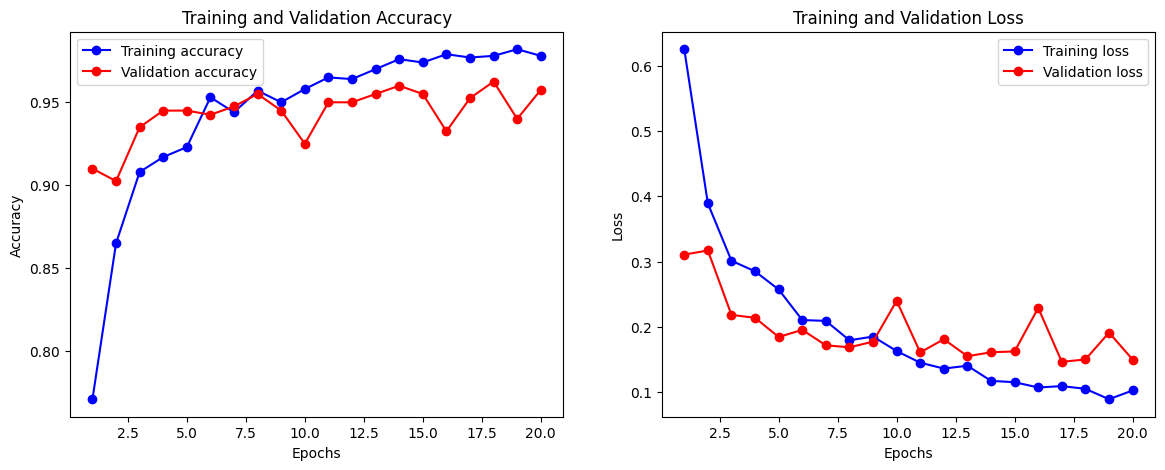

In [ ]:
# Extracting data from history
accuracy = history_densnet.history['accuracy']
val_accuracy = history_densnet.history['val_accuracy']
loss = history_densnet.history['loss']
val_loss = history_densnet.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_densnet = densenet_model.evaluate(train_batches,steps=len(train_batches), verbose=0)
val_score_densnet   = densenet_model.evaluate(validation_batches,steps=len(validation_batches), verbose=0)
test_score_densnet  = densenet_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss DensNet 201 Model: {train_score_densnet[0]} ... Training accuracy DensNet 201 Model: {train_score_densnet[1]}')
print(f'Validation loss DensNet 201 Model: {val_score_densnet[0]} ... Validation accuracy DensNet 201 Model: {val_score_densnet[1]}')
print(f'Test loss DensNet 201 Model: {test_score_densnet[0]} ... Test accuracy DensNet 201 Model: {test_score_densnet[1]}')

Training loss DensNet 201 Model: 0.07801482081413269 ... Training accuracy DensNet 201 Model: 0.9900000095367432
Validation loss DensNet 201 Model: 0.1498645693063736 ... Validation accuracy DensNet 201 Model: 0.9574999809265137
Test loss DensNet 201 Model: 0.21915659308433533 ... Test accuracy DensNet 201 Model: 0.925000011920929


# 5. **MobileNet V2** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications import MobileNetV2

input_tensor = Input(shape=(224, 224, 3))
base_model1 = MobileNetV2(input_tensor=input_tensor, weights='imagenet', include_top=False)

x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)

mobile_model = Model(inputs=base_model1.input, outputs=predictions)

# Freze Layers
for layer in base_model1.layers:
    layer.trainable = False

mobile_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history_mobilenet = mobile_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/20
100/100 [==============================] - 12s 88ms/step - loss: 1.1267 - accuracy: 0.6020 - val_loss: 0.6960 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - 8s 75ms/step - loss: 0.6670 - accuracy: 0.7620 - val_loss: 0.4949 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - 8s 83ms/step - loss: 0.6018 - accuracy: 0.7940 - val_loss: 0.4381 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - 7s 74ms/step - loss: 0.5330 - accuracy: 0.8030 - val_loss: 0.4155 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - 8s 76ms/step - loss: 0.4547 - accuracy: 0.8510 - val_loss: 0.4669 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 6/20
100/100 [==============================] - 8s 81ms/step - loss: 0.4804 - accuracy: 0.8320 - val_loss: 0.3988 - val_accuracy: 0.8650 - lr: 0.0010


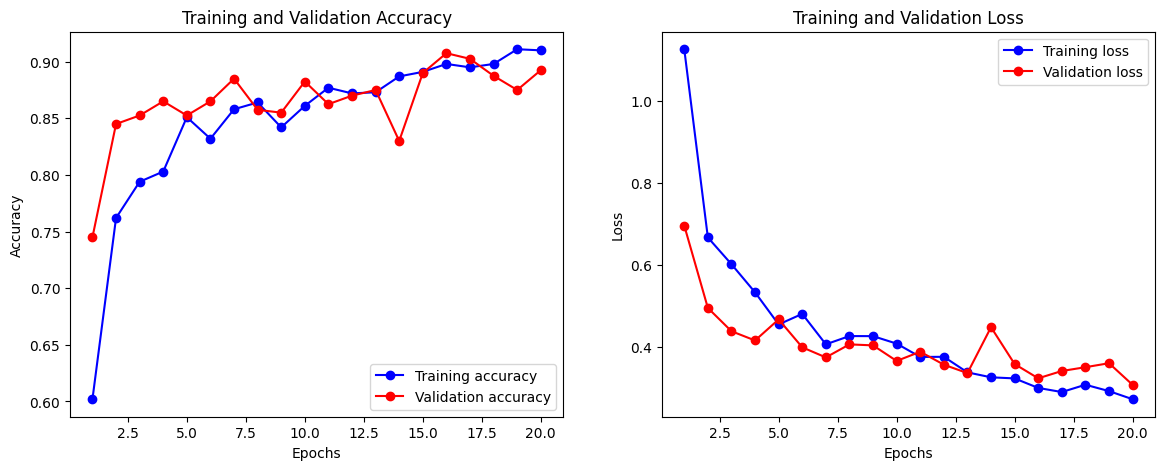

In [ ]:
# Extracting data from history
accuracy = history_mobilenet.history['accuracy']
val_accuracy = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_mobilenet = mobile_model.evaluate(train_batches,steps=len(train_batches), verbose=0)
val_score_mobilenet   = mobile_model.evaluate(validation_batches,steps=len(validation_batches), verbose=0)
test_score_mobilenet  = mobile_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss MobileNet V2: {train_score_mobilenet[0]} ... Training accuracy MobileNet V2: {train_score_mobilenet[1]}')
print(f'Validation loss MobileNet V2: {val_score_mobilenet[0]} ... Validation accuracy MobileNet V2: {val_score_mobilenet[1]}')
print(f'Test loss MobileNet V2: {test_score_mobilenet[0]} ... Test accuracy MobileNet V2: {test_score_mobilenet[1]}')

Training loss MobileNet V2: 0.1864326447248459 ... Training accuracy MobileNet V2: 0.9390000104904175
Validation loss MobileNet V2: 0.30713897943496704 ... Validation accuracy MobileNet V2: 0.8924999833106995
Test loss MobileNet V2: 0.5336159467697144 ... Test accuracy MobileNet V2: 0.8600000143051147


# 6. **Incpetion V3** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add classification layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)
inception_model = tf.keras.Model(inputs, outputs)

inception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_inception = inception_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/20
100/100 [==============================] - 16s 100ms/step - loss: 0.6637 - accuracy: 0.7840 - val_loss: 0.2509 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - 7s 74ms/step - loss: 0.3540 - accuracy: 0.9040 - val_loss: 0.2298 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - 7s 72ms/step - loss: 0.2457 - accuracy: 0.9270 - val_loss: 0.2634 - val_accuracy: 0.9175 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - 8s 82ms/step - loss: 0.2466 - accuracy: 0.9240 - val_loss: 0.1917 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - 9s 88ms/step - loss: 0.1872 - accuracy: 0.9450 - val_loss: 0.2187 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 6/20
100/100 [==============================] - 8s 76ms/step - loss: 0.1479 - accuracy: 0.9600 - val_loss: 0.2119 - val_accuracy: 0.9350 - lr: 0.00

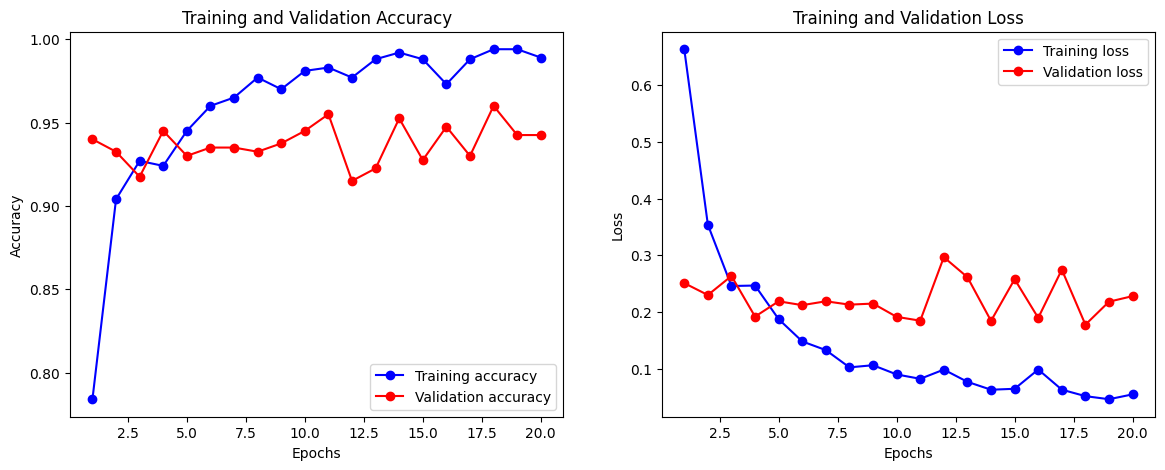

In [ ]:
# Extracting data from history
accuracy = history_inception.history['accuracy']
val_accuracy = history_inception.history['val_accuracy']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_inception = inception_model.evaluate(train_batches, steps=len(train_batches), verbose=0)
val_score_inception   = inception_model.evaluate(validation_batches, steps=len(validation_batches), verbose=0)
test_score_inception  = inception_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss InceptionV3 model : {train_score_inception[0]} ... Training accuracy InceptionV3 model: {train_score_inception[1]}')
print(f'Validation loss InceptionV3 model: {val_score_inception[0]} ... Validation accuracy InceptionV3 model: {val_score_inception[1]}')
print(f'Test loss InceptionV3 model: {test_score_inception[0]} ... Test accuracy InceptionV3 model: {test_score_inception[1]}')

Training loss InceptionV3 model : 0.030763760209083557 ... Training accuracy InceptionV3 model: 1.0
Validation loss InceptionV3 model: 0.22788898646831512 ... Validation accuracy InceptionV3 model: 0.9424999952316284
Test loss InceptionV3 model: 0.3988513946533203 ... Test accuracy InceptionV3 model: 0.9399999976158142


# 7. **ViT-B/16**  Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
import tensorflow_hub as hub

# Download ViT-B/16 model from TensorFlow Hub
vit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
vit_model = hub.KerasLayer(vit_model_url, trainable=False)

# Create a custom model based on ViT
inputs = Input(shape=(224, 224, 3))
vit_features = vit_model(inputs)
x = Dense(512, activation='relu')(vit_features)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)

vit_model = Model(inputs=inputs, outputs=outputs)

vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history_vit_model = vit_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
100/100 [==============================] - 26s 124ms/step - loss: 1.8341 - accuracy: 0.7750 - val_loss: 0.3507 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - 13s 126ms/step - loss: 0.3956 - accuracy: 0.9070 - val_loss: 0.2109 - val_accuracy: 0.9425 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - 10s 104ms/step - loss: 0.2880 - accuracy: 0.9230 - val_loss: 0.2082 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - 11s 107ms/step - loss: 0.2112 - accuracy: 0.9480 - val_loss: 0.2203 - val_accuracy: 0.9350 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - 10s 105ms/step - loss: 0.2718 - accuracy: 0.9190 - val_loss: 0.2370 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 6/20
100/100 [==============================] - 12s 125ms/step - loss: 0.2370 - accuracy: 0.9280 - val_loss: 0.2085 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 7/20
100/100 [==============================] 

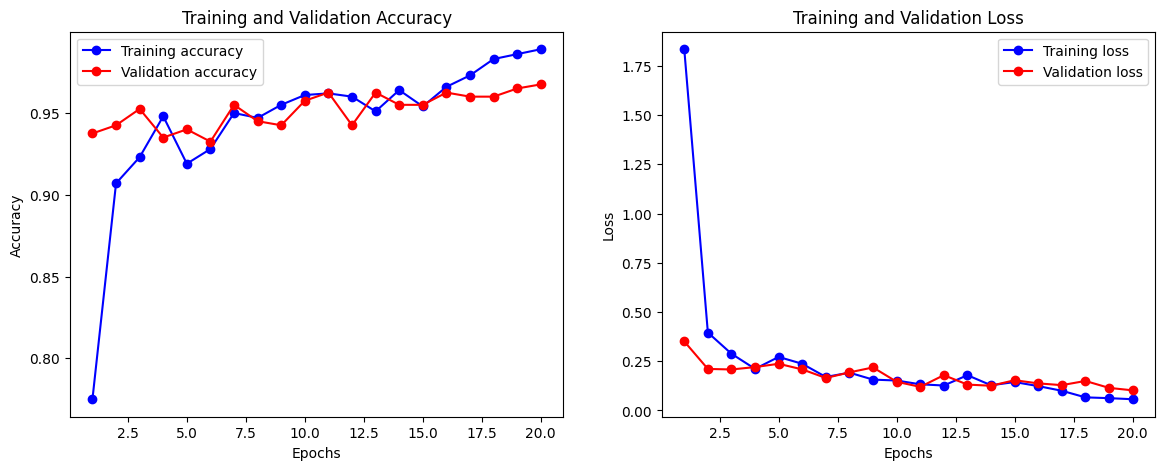

In [ ]:
# Extracting data from history
accuracy = history_vit_model.history['accuracy']
val_accuracy = history_vit_model.history['val_accuracy']
loss = history_vit_model.history['loss']
val_loss = history_vit_model.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_vit_model = vit_model.evaluate(train_batches, steps=len(train_batches), verbose=0)
val_score_vit_model   = vit_model.evaluate(validation_batches, steps=len(validation_batches), verbose=0)
test_score_vit_model  = vit_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss InceptionV3 model : {train_score_vit_model[0]} ... Training accuracy InceptionV3 model: {train_score_vit_model[1]}')
print(f'Validation loss InceptionV3 model: {val_score_vit_model[0]} ... Validation accuracy InceptionV3 model: {val_score_vit_model[1]}')
print(f'Test loss InceptionV3 model: {test_score_vit_model[0]} ... Test accuracy InceptionV3 model: {test_score_vit_model[1]}')

Training loss InceptionV3 model : 0.03089606948196888 ... Training accuracy InceptionV3 model: 0.996999979019165
Validation loss InceptionV3 model: 0.10229833424091339 ... Validation accuracy InceptionV3 model: 0.9674999713897705
Test loss InceptionV3 model: 0.12380547821521759 ... Test accuracy InceptionV3 model: 0.9599999785423279
